In [1]:
from typing import List,Tuple
from random import choices
from functools import partial
import sys
sys.path.append('/kaggle/input/gt-proj')

# from F import Genome, stock_data, Population, FitnessFunc, populate, generate_fuzzy, run_evolution, fitness, mutation

from FuzzyLogic import Genome,stock_data,Population,FitnessFunc,populate,generate_fuzzy,run_evolution,fitness,mutation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plotter

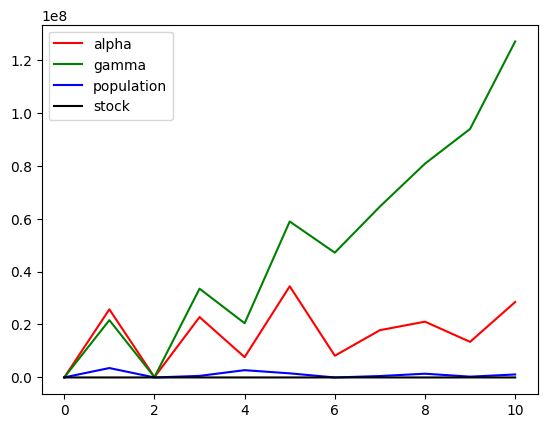

In [2]:



#Change '<Data_File_Name.>.csv' here
df = pd.read_csv('/kaggle/input/gt-proj/Data.csv')

open = list(df['Open'])
close = list(df['Close'])
high = list(df['High'])
low = list(df['Low'])

stk_data = [
    stock_data(open[i],close[i],high[i],low[i]) for i in range(len(open))
]

#Transaction: Selling/Buying of stocks is defined here, using a buy/sell signal
def transaction(genome:Genome,data:stock_data,curr_time:int)->int:
    A = generate_fuzzy(data,curr_time)  #Generate fuzzy row of features
    M = 20  #Max. stocks that can be bought
    b = []
    for j in range(len(genome[0])):
        bj = []
        for i in range(len(genome)):
            bj.append(min(A[i],genome[i][j]))
        b.append(max(bj))

    num = 0
    den = 0

    lambda_cap = [i/4 for i in range(1,5)]
    for j in range(len(genome[0])):
        num+=b[j]*lambda_cap[j]
        den+=lambda_cap[j]
    U = (num/den-0.5)*M/(1-0.5)*data[curr_time].open        #Buy/Sell Signal
    # print(U)
    return U #The price of stocks sold or bought

#For selection of elite parents
def selection_pair_coev(population:Population,moni:List[float])->Tuple[Genome,Genome]:
    return choices(
        population,
        weights = sorted(moni),
        k = 2
    )

#For crossover among selected parents
def crossover_coev(a: Genome, b: Genome)->Tuple[Genome,Genome]:
    for i in range(len(a)):
        length = len(a[0])
        x = np.random.randint(1,length)
        a[i],b[i] = a[i][0:x]+b[i][x:],b[i][0:x]+a[i][x:]

    return a,b

#Running evolution amongst one's own individuals
def run_self_evolution(population:Population,moni:List[float],gen_lim:int = 20)->Population:
    for i in range(gen_lim):
        parent_a,parent_b = selection_pair_coev(population,moni)
        offspring_a,offspring_b = crossover_coev(parent_a,parent_b)
        ind_a = population.index(parent_a)
        ind_b = population.index(parent_b)
        offspring_a = mutation(offspring_a,1)
        offspring_b = mutation(offspring_b,1)
        population[ind_a] = offspring_a
        population[ind_b] = offspring_b

    return population

#Running cross-evolution among different populations
def run_cross_evolution(population_elite:Population,population_inf:Population)->Population:
    indInList = []
    for i in range(4):
        ind = np.random.randint(0,40)
        while(ind in indInList):
            ind = np.random.randint(0,40)
        indInList.append(ind)
        parent_a,parent_b = population_elite[0],population_inf[ind]
        offspring_a,offspring_b = crossover_coev(parent_a,parent_b)
        offspring_sel = choices([offspring_a,offspring_b],weights=[1,1],k=1)[0]
        offspring_a = mutation(offspring_sel,1)
        population_inf[ind] = offspring_a

    return population_inf

#Generating an initial population of Matrices M
n = 5 #No. of features observed -> Rows of Matrix M
m = 4 #No. of columns of Matrix M 
pop_size = 10
M_pop = populate(pop_size,n,m)

#Generating 
population,i = run_evolution(
    populate_func=partial(
        populate,pop_size=10,rows=n,genome_length=m
    ),
    fitness_func=partial(
        fitness,data=stk_data
    ),
    fitness_limit=11,
    generation_limit=100
)

# print(population[0])

#alpha, omega -> Populations of two stockbroker agents : Players in the game
alpha = []
alpha_moni = []
omega = []
omega_moni = []
pop_moni = 0    #Comparing against an individual without any evolution in strategies
    
for i in range(40):
    alpha.append(mutation(population[0]))
    alpha_moni.append(400)
    
for i in range(40):
    omega.append(mutation(population[0]))
    omega_moni.append(400)

#initial wealth of all players is Rs. 30000
tot_win_alpha = [30000]       
tot_win_omega = [30000]
tot_win_pop = [30000]

#Select two elite individuals to compare from alpha and omega populations, respectively
selected_alpha_ind = 0
selected_omega_ind = 0

for i in range(10):
    day = np.random.randint(0,70)
    for days in range(day,day+70):
        c = 0
        ind_alpha = []
        ind_omega = []
        for k in range(10):
            x = np.random.randint(0,39)
            y = np.random.randint(0,39)
            while(x in ind_alpha or y in ind_omega):
                if(x in ind_alpha):
                    x = np.random.randint(0,39)
                if(y in ind_omega):
                    y = np.random.randint(0,39)
            
            ind_alpha.append(x)
            ind_omega.append(y)

            for j in range(40):
                alp = transaction(alpha[j],stk_data,days)
                alp-=0.01*alp
                ome = transaction(omega[j],stk_data,days)
                ome-=0.01*ome
                alpha_moni[j]=alpha_moni[j]+alp if alpha_moni[j]+alp>=0 else alpha_moni[j]
                omega_moni[j]=omega_moni[j]+ome if omega_moni[j]+ome>=0 else omega_moni[j]
            
            m=transaction(population[0],stk_data,days)
            m-=0.01*m
            pop_moni=pop_moni+m if pop_moni+m>=0 else pop_moni

            #Loser pays 2% of his bank balance to winner

            if(pop_moni<alpha_moni[x]):
                alpha_moni[x]+=0.02*pop_moni
                pop_moni-=0.02*pop_moni
            elif(pop_moni>alpha_moni[x]):
                pop_moni+=0.02*alpha_moni[x]
                alpha_moni[x]-=0.02*alpha_moni[x]

            if(pop_moni<omega_moni[x]):
                omega_moni[x]+=0.02*pop_moni
                pop_moni-=0.02*pop_moni
            elif(pop_moni>omega_moni[x]):
                pop_moni+=0.02*omega_moni[x]
                omega_moni[x]-=0.02*omega_moni[x]

            if(alpha_moni[x]<omega_moni[y]):
                omega_moni[y]+=0.02*alpha_moni[x]
                alpha_moni[x]-=0.02*alpha_moni[x]
                c-=1
            elif(alpha_moni[x]>omega_moni[y]):
                alpha_moni[x]+=0.02*omega_moni[y]
                omega_moni[y]-=0.02*omega_moni[y]
                c+=1

    tot_win_alpha.append(alpha_moni[selected_alpha_ind])
    tot_win_omega.append(omega_moni[selected_omega_ind])
    tot_win_pop.append(pop_moni)

    #Self-Evolution run after every 70 days of trading
    alpha = run_self_evolution(alpha,alpha_moni)
    omega = run_self_evolution(omega,omega_moni)

    #Cross-Evolution run when loser tries to adopt and evolve with winner's strategies
    if(c>0):
        omega = run_cross_evolution(alpha,omega)

    elif(c<0):
        alpha = run_cross_evolution(omega,alpha)
    
# print([i for i in range(len(tot_win_alpha))])
tot_win_alpha_np = np.array(tot_win_alpha)
tot_win_omega_np = np.array(tot_win_omega)
tot_win_pop_np = np.array(tot_win_pop)
x_alpha_np = np.array([i for i in range(len(tot_win_alpha))])
# print(tot_win_alpha_np)
# print(tot_win_pop_np)
plotter.plot(x_alpha_np,tot_win_alpha_np,color='red', label='alpha')
plotter.plot(x_alpha_np,tot_win_omega_np,color='green', label='gamma')
plotter.plot(x_alpha_np,tot_win_pop_np,color='blue', label='population')
plotter.plot(x_alpha_np,open[:len(x_alpha_np)],color='black', label='stock')
plotter.legend()
plotter.show()

# print(tot_win_alpha)
# print(tot_win_omega)
